In [1]:
import sqlalchemy
import matplotlib.pyplot as plt 
import pandas as pd
pd.option_context('display.max_rows',None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from math import sqrt, ceil
import fbprophet
add_data_path = r'C:\Users\ahmed\OneDrive\Desktop\CODE_PFE_ETL\prev\rnn\data\convertcsv.csv'
add_d21_path = r'C:\Users\ahmed\OneDrive\Desktop\CODE_PFE_ETL\prev\rnn\data\d2021.csv'


#Importation des données de la base MSSQL avec sqlalchemy
def connexion_bd():
    server="localhost"
    database="GIPA"
    driver ="ODBC Driver 17 for SQL Server"
    con = f'mssql://@{server}/{database}?driver={driver}'
    engine = sqlalchemy.create_engine(con,fast_executemany=True)
    con = engine.connect()
    sql = "select Article,DateFacture,CA from GIPA.dbo.faits_resultat"
    df = pd.read_sql(sql,con)  #mise en place des données dans un DataFrame 
    return df



def transformation_données_2021():
    data21 = pd.read_csv(add_d21_path)
    data21.drop("Date",axis=1,inplace=True)
    array_d21 = np.array(data21)
    return array_d21


Importing plotly failed. Interactive plots will not work.


In [2]:
df = connexion_bd()
df['DateFacture'] = pd.DatetimeIndex(df['DateFacture'])
df.index = df['DateFacture']
group = df.groupby(pd.Grouper(freq='M'))  # update for v0.21+
df_c = group.sum()
data_test = pd.read_csv(add_data_path)
data_test.set_index('Date',inplace=True)
#jointure des deux df 
df_finale = pd.concat([data_test,df_c])
df_finale.reset_index(inplace=True)
df_finale['index'] = pd.to_datetime(df_finale['index'])

In [3]:
df_finale_indexed = df_finale.drop('index',axis=1)

In [4]:
max_p = 2
max_q = 2
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)
modelSelection = pd.DataFrame(index=range(pattern),columns=["model", "aic"])
num =0


In [5]:
import statsmodels.api as sm
for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            df_finale_indexed, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,4), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1
#prevScore = sqrt(mean_squared_error(array_d21,df_resultat['previsions']))
#print('RMSE des prévisions par rapport au données réelles: %.2f RMSE' % (prevScore))


In [6]:
print(modelSelection[modelSelection.aic == min(modelSelection.aic)])


                            model      aic
91  order=(2,1,2), season=(0,1,1) 1652.134


In [8]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(df_finale, order=(2,1,2), seasonal_order=(0,1,1,12))


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
array_d21 = pd.DataFrame(transformation_données_2021())

In [ ]:
df_resultat = pd.DataFrame()
df_resultat['donnees reelles'] = array_d21
res = results.predict(start=59,end=70,dynamic=True)


In [ ]:
df_res = pd.DataFrame(res)

In [ ]:
df_res.reset_index(inplace=True)

In [ ]:
df_res['predicted_mean']

0     6338232.829
1     7894100.170
2     7672244.006
3     8678308.146
4     8731854.197
5    20405180.631
6    30578074.845
7    30441485.833
8    25528787.927
9     7356678.856
10    6086549.000
11    4845244.774
Name: predicted_mean, dtype: float64

In [ ]:
df_resultat['previsions'] = df_res['predicted_mean']

In [ ]:
df_resultat

,donnees reelles,previsions
0,10383832.490,6338232.829
1,9885975.820,7894100.170
2,10342805.460,7672244.006
3,10626768.800,8678308.146
4,23938735.400,8731854.197
5,32987884.600,20405180.631
6,33342000.490,30578074.845
7,28825611.200,30441485.833
8,9521883.300,25528787.927
9,8235559.580,7356678.856


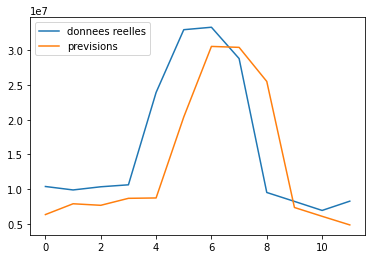

In [ ]:
df_resultat.plot()

In [ ]:
from sklearn.metrics import mean_squared_error
prevScore = sqrt(mean_squared_error(array_d21,df_resultat['previsions']))
print('RMSE des prévisions par rapport au données réelles: %.2f RMSE' % (prevScore))

RMSE des prévisions par rapport au données réelles: 7640430.64 RMSE
